In [1]:
# !pip install biopython
!pip install --upgrade --no-cache-dir biopython
!pip install rdkit-pypi
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-geometric
!pip install fair-esm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 64.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 7.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.3 MB/s eta 0:00:0000:01


In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import pickle
from torch.utils.data import DataLoader, random_split
import itertools
import seaborn as sns
from utils import plot_hyperparameter_results, plot_hyperparameter_results_enhanced
from graph_utils import custom_collate,DrugTargetGNN,DrugProteinDataset





In [3]:
pIC50=np.load('/kaggle/input/drug-virus-features/pIC50.npy')
with open("/kaggle/input/drug-virus-features/drug_graphs.pkl", "rb") as f:
    drug_graphs = pickle.load(f)
with open("/kaggle/input/drug-virus-features/protein_graphs.pkl", "rb") as f:
    protein_graphs = pickle.load(f)



In [9]:

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for protein_graph, drug_graphs, values in dataloader:
            protein_graph = protein_graph.to(device)
            drug_graphs = drug_graphs.to(device)
            values = values.to(device)

            outputs = model(protein_graph, drug_graphs)
            all_preds.append(outputs.cpu())
            all_labels.append(values.cpu())
         
    preds = torch.cat(all_preds).numpy()
   
    values = torch.cat(all_labels).numpy()

    mse = mean_squared_error(values, preds)
    rmse = mse ** 0.5
    pearson_corr, _ = pearsonr(values, preds)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "Pearson": pearson_corr
    }


In [10]:
hidden_dims = [64, 128, 256]
batch_sizes = [64, 128, 256]


In [ ]:
dataset = DrugProteinDataset(protein_graphs, drug_graphs, pIC50)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  
)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

# Iterate over hidden_dim and batch_size combinations
for hidden_dim, batch_size in tqdm(itertools.product(hidden_dims, batch_sizes)):
    print(f"\nTesting hidden_dim={hidden_dim}, batch_size={batch_size}")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    model = DrugTargetGNN(hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()  # for regression
    # Training
    model.train()
    for epoch in range(50):
        total_loss = 0
        for protein_graph, drug_graph, values in train_loader:
            protein_graph = protein_graph.to(device)
            drug_graph = drug_graph.to(device)
            values = values.to(device)

            optimizer.zero_grad()
            outputs = model(protein_graph, drug_graph)
            loss = criterion(outputs, values)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

    # Validation
    val_metrics = evaluate(model, val_loader, device)

    results.append({
            'hidden_dim': hidden_dim,
            'batch_size': batch_size,
            'MSE': val_metrics['MSE'],
            'RMSE': val_metrics['RMSE'],
            'Pearson': val_metrics['Pearson']
    })


results_df = pd.DataFrame(results)



0it [00:00, ?it/s]


Testing hidden_dim=64, batch_size=64


1it [16:34, 995.00s/it]


Testing hidden_dim=64, batch_size=128


2it [32:15, 962.67s/it]


Testing hidden_dim=64, batch_size=256


3it [47:29, 940.62s/it]


Testing hidden_dim=128, batch_size=64


4it [1:04:00, 960.55s/it]


Testing hidden_dim=128, batch_size=128


5it [1:19:37, 951.91s/it]


Testing hidden_dim=128, batch_size=256


6it [1:34:53, 939.72s/it]


Testing hidden_dim=256, batch_size=64


7it [1:51:25, 956.94s/it]


Testing hidden_dim=256, batch_size=128


8it [2:07:01, 950.17s/it]


Testing hidden_dim=256, batch_size=256


9it [2:22:05, 947.23s/it]


In [ ]:
sns.set(style="whitegrid")

hyperparameters = {
'hidden_dim' : [64, 128, 256],
'batch_size' : [64, 128, 256],

}

metrics = ['MSE', 'RMSE', 'Pearson']

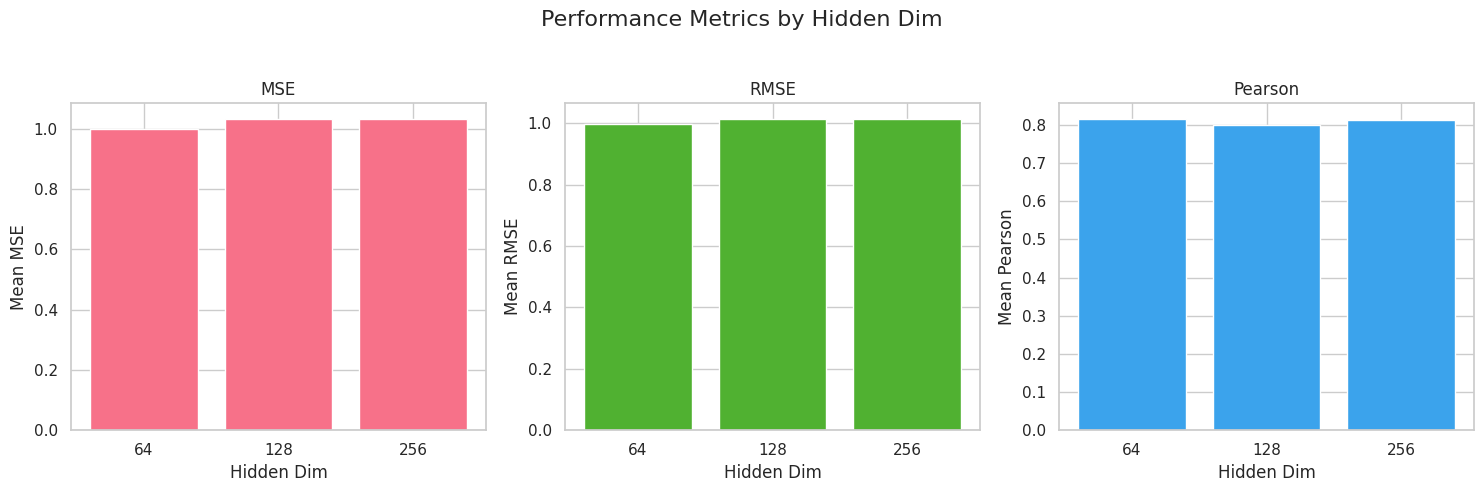

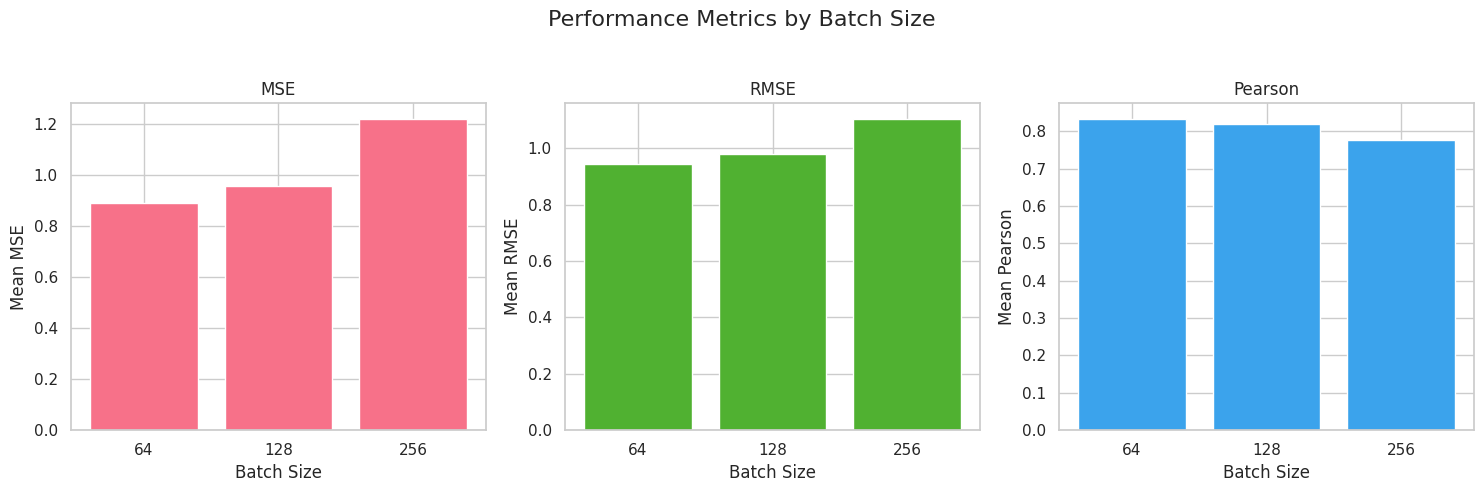

Best Hyperparameters:
{'hidden_dim': 64.0, 'batch_size': 64.0}
Best Metrics:
{'MSE': 0.8800012469291687, 'RMSE': 0.9380838165799305, 'Pearson': 0.8375039100646973}


In [ ]:

for hyperparam, values in hyperparameters.items():
    plot_hyperparameter_results(metrics,hyperparam, values, results_df)

best_row = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Hyperparameters:")
print({
    'hidden_dim': best_row['hidden_dim'],
    'batch_size': best_row['batch_size']
})

print("Best Metrics:")
print({
    'MSE': best_row['MSE'],
    'RMSE': best_row['RMSE'],
    'Pearson': best_row['Pearson']
})

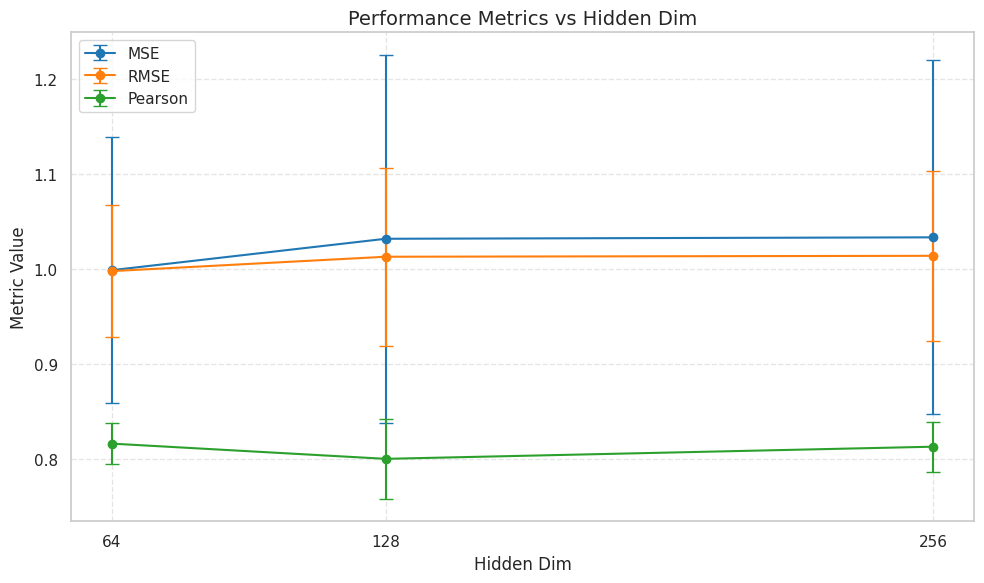

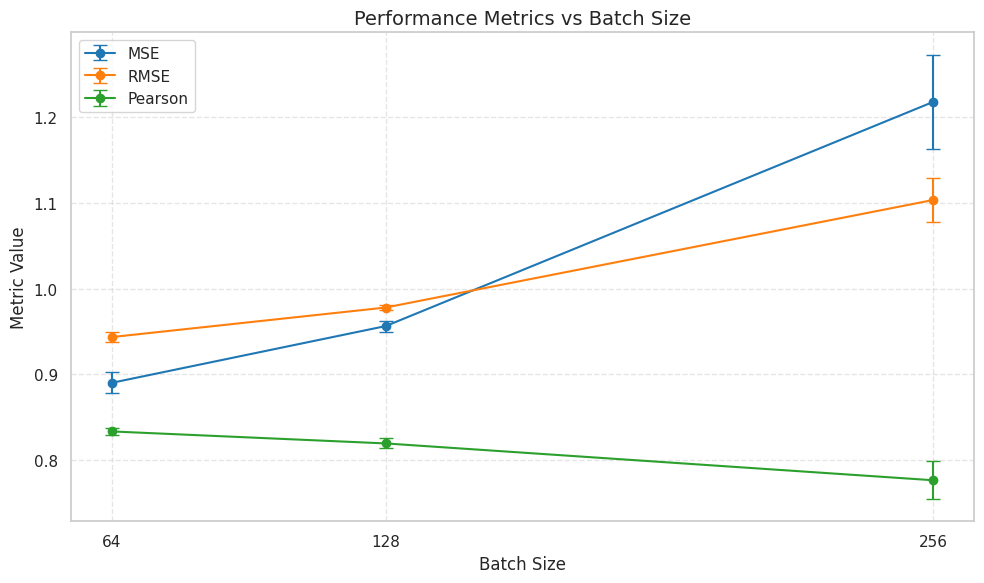

In [ ]:

for hyperparam, values in hyperparameters.items():
    plot_hyperparameter_results_enhanced(metrics,hyperparam, values, results_df)

In [ ]:

hidden_dim=int(best_row['hidden_dim'])
batch_size=int(best_row['batch_size'])


combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

model = DrugTargetGNN(hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # for regression
# Training
model.train()
for epoch in range(50):
    total_loss = 0
    print(f"\nEpoch {epoch+1}")
    
    for protein_graph, drug_graph, values in combined_loader:
        protein_graph = protein_graph.to(device)
        drug_graph = drug_graph.to(device)
        values = values.to(device)

        optimizer.zero_grad()
        outputs = model(protein_graph, drug_graph)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(combined_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")





Epoch 1
Epoch 1 Average Loss: 3.5827

Epoch 2
Epoch 2 Average Loss: 2.1621

Epoch 3
Epoch 3 Average Loss: 2.0259

Epoch 4
Epoch 4 Average Loss: 1.9243

Epoch 5
Epoch 5 Average Loss: 1.8842

Epoch 6
Epoch 6 Average Loss: 1.7017

Epoch 7
Epoch 7 Average Loss: 1.6267

Epoch 8
Epoch 8 Average Loss: 1.5475

Epoch 9
Epoch 9 Average Loss: 1.4297

Epoch 10
Epoch 10 Average Loss: 1.3846

Epoch 11
Epoch 11 Average Loss: 1.3465

Epoch 12
Epoch 12 Average Loss: 1.2942

Epoch 13
Epoch 13 Average Loss: 1.2565

Epoch 14
Epoch 14 Average Loss: 1.2102

Epoch 15
Epoch 15 Average Loss: 1.1794

Epoch 16
Epoch 16 Average Loss: 1.1438

Epoch 17
Epoch 17 Average Loss: 1.1057

Epoch 18
Epoch 18 Average Loss: 1.0421

Epoch 19
Epoch 19 Average Loss: 1.0234

Epoch 20
Epoch 20 Average Loss: 0.9844

Epoch 21
Epoch 21 Average Loss: 0.9550

Epoch 22
Epoch 22 Average Loss: 0.9388

Epoch 23
Epoch 23 Average Loss: 0.9301

Epoch 24
Epoch 24 Average Loss: 0.8703

Epoch 25
Epoch 25 Average Loss: 0.8657

Epoch 26
Epoch 26

In [ ]:
# Save the model
# torch.save(model.state_dict(), f"drug_target_model.pth")

with open(f"drug_target_model.pkl", "wb") as f:
    pickle.dump(model, f)



In [22]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_metrics = evaluate(model, test_loader, device)
print("Test Metrics:", test_metrics)

Test Metrics: {'MSE': 0.83284396, 'RMSE': 0.9126028486321487, 'Pearson': 0.8474896}
